In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
%matplotlib inline
pd.set_option("display.precision", 2)

In [112]:
#Generate dataset
def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5,
      na_value=None,
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  return dataset

class PackNumericFeatures(object):
  def __init__(self, names):
    self.names = names

  def __call__(self, features, labels):
    numeric_features = [features.pop(name) for name in self.names]
    numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    numeric_features = tf.stack(numeric_features, axis=-1)
    features['numeric'] = numeric_features

    return features, labels

def show_batch(dataset):
  for batch, label in dataset.take(1):
      print("'total cases': {}".format(label))
      print("features:")
      for key, value in batch.items():
        print("{:20s}: {}".format(key,value.numpy()))

In [113]:
LABEL_COLUMN = 'total_cases'
NUMERIC_COLUMNS = ['year',
                    'weekofyear',
                    'ndvi_ne',
                    'ndvi_nw',
                    'ndvi_se',
                    'ndvi_sw',
                    'precipitation_amt_mm',
                    'reanalysis_air_temp_k',
                    'reanalysis_avg_temp_k',
                    'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k',
                    'reanalysis_min_air_temp_k',
                    'reanalysis_precip_amt_kg_per_m2',
                    'reanalysis_relative_humidity_percent',
                    'reanalysis_sat_precip_amt_mm',
                    'reanalysis_specific_humidity_g_per_kg',
                    'reanalysis_tdtr_k',
                    'station_avg_temp_c',
                    'station_diur_temp_rng_c',
                    'station_max_temp_c',
                    'station_min_temp_c',
                    'station_precip_mm']
CATEGORICAL_COLUMNS = ['city']
CSV_COLUMNS = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
CSV_COLUMNS_NO_LABEL = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
CATEGORIES = {
    'city': ['sj', 'iq']
}

NEW_COLUMNS = ['total_cases', 'year', 'weekofyear', 'station_avg_temp_c']

DATASET_SIZE = 1456
TRAIN_DATASET_FRAC = 0.8
train_file = './dengue_features_train_with_out.csv'

print(len(NEW_COLUMNS))

4


In [114]:
#Get training dataset

def extract_data(train_file, columns):
    all_data = pd.read_csv(train_file, usecols = columns)
    # map categorical to columns
    for feature_name in CATEGORICAL_COLUMNS:
        mapping_dict = { CATEGORIES[feature_name][i] : CATEGORIES[feature_name][i] for i in range(0, len(CATEGORIES[feature_name]) ) }
        all_data[feature_name] = all_data[feature_name].map(mapping_dict)
    
    all_data = pd.get_dummies(all_data, prefix='', prefix_sep='')
    all_data = all_data.interpolate(method ='linear', limit_direction ='forward')
    
    return all_data

all_data = extract_data(train_file, CSV_COLUMNS)

# Split data into train and test
train_data = all_data.sample(frac=TRAIN_DATASET_FRAC,random_state=0)
test_data = all_data.drop(train_data.index)

print(len(train_data))
print(len(test_data))

train_y = train_data.pop(LABEL_COLUMN)
test_y = test_data.pop(LABEL_COLUMN)

# Display one batch from dataset
# show_batch(train_dataset)
train_data.head()

1165
291


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
511,2000,8,0.18,0.21,0.15,0.15,7.67,297.09,297.22,292.17,...,7.67,13.67,1.99,24.77,6.63,28.3,20.6,3.8,0,1
961,2000,51,0.27,0.17,0.23,0.30,3.90,300.41,302.00,291.09,...,3.90,13.19,13.00,28.20,12.28,35.0,21.0,0.0,1,0
231,1994,40,0.10,0.07,0.12,0.19,0.63,300.38,300.50,295.36,...,0.63,16.74,2.63,28.71,6.90,34.4,24.4,8.2,0,1
687,2003,29,-0.06,-0.11,0.22,0.19,62.57,300.15,300.34,296.32,...,62.57,17.72,1.91,27.47,5.89,31.7,21.7,43.0,0,1
34,1990,52,0.30,0.28,0.17,0.16,0.00,298.04,298.09,292.11,...,0.00,13.68,2.29,25.16,5.84,28.9,21.1,20.9,0,1


In [115]:
train_stats = all_data.describe()
train_stats.pop(LABEL_COLUMN)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
year,1456.0,2001.03,5.41,1990.00,1997.00,2002.00,2005.00,2010.00
weekofyear,1456.0,26.50,15.02,1.00,13.75,26.50,39.25,53.00
ndvi_ne,1456.0,0.13,0.14,-0.41,0.04,0.12,0.23,0.51
ndvi_nw,1456.0,0.13,0.12,-0.46,0.05,0.12,0.21,0.45
ndvi_se,1456.0,0.20,0.07,-0.02,0.15,0.20,0.25,0.54
ndvi_sw,1456.0,0.20,0.08,-0.06,0.14,0.19,0.25,0.55
precipitation_amt_mm,1456.0,45.70,43.65,0.00,9.79,38.32,70.23,390.60
reanalysis_air_temp_k,1456.0,298.70,1.36,294.64,297.66,298.64,299.83,302.20
reanalysis_avg_temp_k,1456.0,299.22,1.26,294.89,298.26,299.29,300.21,302.93
reanalysis_dew_point_temp_k,1456.0,295.24,1.53,289.64,294.12,295.64,296.46,298.45


In [116]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


cols_to_norm = ['precipitation_amt_mm',
                    'reanalysis_air_temp_k',
                    'reanalysis_avg_temp_k',
                    'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k',
                    'reanalysis_min_air_temp_k',
                    'reanalysis_precip_amt_kg_per_m2',
                    'reanalysis_relative_humidity_percent',
                    'reanalysis_sat_precip_amt_mm',
                    'reanalysis_specific_humidity_g_per_kg',
                    'reanalysis_tdtr_k',
                    'station_avg_temp_c',
                    'station_diur_temp_rng_c',
                    'station_max_temp_c',
                    'station_min_temp_c',
                    'station_precip_mm']
cols_to_scale = ['year',
                    'weekofyear']
def preproc_data(data):
    new_data = data.copy()
    # Normalize temp and percipation
    new_data[cols_to_norm] = StandardScaler().fit_transform(new_data[cols_to_norm])

    # Scale year and week no but within (0,1)
    new_data[cols_to_scale] = MinMaxScaler(feature_range=(0, 1)).fit_transform(new_data[cols_to_scale])
    
    return new_data

train_data = preproc_data(train_data)
all_y = all_data.pop(LABEL_COLUMN)
all_data = preproc_data(all_data)
test_data = preproc_data(test_data)
train_stats = train_data.describe()
train_stats = train_stats.transpose()
train_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
511,0.50,0.13,0.18,0.21,0.15,0.15,-0.91,-1.19,-1.60,-1.99,...,-0.91,-1.97,-0.83,-1.89,-0.69,-2.10,-0.97,-0.80,0,1
961,0.50,0.96,0.27,0.17,0.23,0.30,-1.00,1.27,2.22,-2.70,...,-1.00,-2.28,2.26,0.79,1.94,1.29,-0.71,-0.89,1,0
231,0.20,0.75,0.10,0.07,0.12,0.19,-1.08,1.25,1.02,0.09,...,-1.08,0.01,-0.65,1.19,-0.57,0.98,1.49,-0.69,0,1
687,0.65,0.54,-0.06,-0.11,0.22,0.19,0.46,1.08,0.90,0.71,...,0.46,0.64,-0.85,0.22,-1.04,-0.38,-0.26,0.14,0,1
34,0.00,0.98,0.30,0.28,0.17,0.16,-1.10,-0.49,-0.91,-2.03,...,-1.10,-1.97,-0.74,-1.58,-1.06,-1.80,-0.65,-0.39,0,1


In [117]:
# Create input function

def input_fn(features, labels, training=True, batch_size=16):
    """An input function for training or evaluating"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(100).repeat()
    
    return dataset.batch(batch_size)

In [142]:
# Build network with 
def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [143]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 64)                1600      
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 5,825
Trainable params: 5,825
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Train the Model.
EPOCHS = 100

# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
  all_data, all_y,
  epochs=EPOCHS, validation_split = 0.2,
                    callbacks=[early_stop])

Train on 1164 samples, validate on 292 samples
Epoch 1/100
1164/1164 [==============================] - 0s 368us/sample - loss: 21.9297 - mae: 21.9297 - mse: 2382.7051 - val_loss: 8.1533 - val_mae: 8.1533 - val_mse: 217.3480
Epoch 2/100
1164/1164 [==============================] - 0s 146us/sample - loss: 20.0074 - mae: 20.0074 - mse: 2209.8291 - val_loss: 8.2453 - val_mae: 8.2453 - val_mse: 219.8994
Epoch 3/100
1164/1164 [==============================] - 0s 159us/sample - loss: 19.4573 - mae: 19.4573 - mse: 2154.7458 - val_loss: 7.0248 - val_mae: 7.0248 - val_mse: 188.1801
Epoch 4/100
1164/1164 [==============================] - 0s 166us/sample - loss: 19.0058 - mae: 19.0058 - mse: 2096.3240 - val_loss: 7.0901 - val_mae: 7.0901 - val_mse: 188.3158
Epoch 5/100
1164/1164 [==============================] - 0s 157us/sample - loss: 19.1457 - mae: 19.1457 - mse: 2081.2722 - val_loss: 7.7993 - val_mae: 7.7993 - val_mse: 209.6761
Epoch 6/100
1164/1164 [==============================] - 0s 170

In [145]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
21,17.12,17.12,1809.29,7.34,7.34,188.35,21
22,16.99,16.99,1805.78,7.47,7.47,189.37,22
23,16.81,16.81,1798.24,7.49,7.49,196.45,23
24,16.92,16.92,1757.86,7.35,7.35,184.11,24
25,16.83,16.83,1817.33,7.29,7.29,192.71,25


In [146]:
loss, mae, mse = model.evaluate(test_data, test_y, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Total_cases".format(mae))

291/291 - 0s - loss: 14.7511 - mae: 14.7511 - mse: 1694.1730
Testing set Mean Abs Error: 14.75 Total_cases


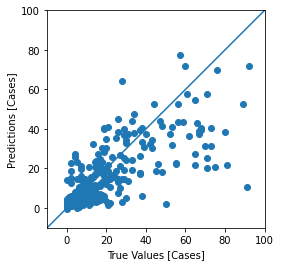

In [147]:
test_predictions = model.predict(test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_y, test_predictions)
plt.xlabel('True Values [Cases]')
plt.ylabel('Predictions [Cases]')
lims = [-10, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [148]:
# Get Test file and preprocess test data

test_file = './dengue_features_test.csv'

org_test_data = extract_data(test_file, CSV_COLUMNS_NO_LABEL)
proc_test_data = preproc_data(org_test_data)
proc_test_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,0.0,0.33,-1.89e-02,-0.02,0.10,0.09,1.15,-0.22,-6.13e-01,-0.58,...,1.15,-0.64,-0.56,-0.68,-0.33,0.40,-0.37,1.19,0,1
1,0.0,0.35,-1.80e-02,-0.01,0.08,0.07,-0.73,-0.23,-6.08e-01,-0.67,...,-0.73,-0.72,-0.72,-1.05,-0.94,-1.31,-0.08,0.01,0,1
2,0.0,0.37,-1.50e-03,-0.02,0.15,0.09,-0.98,0.44,6.04e-03,-0.07,...,-0.98,-0.16,-0.19,0.47,-0.03,0.14,0.27,-0.90,0,1
3,0.0,0.38,2.77e-02,-0.02,0.12,0.13,-1.09,0.60,2.91e-01,-0.66,...,-1.09,-0.73,-0.22,0.57,-0.65,0.40,1.19,-0.97,0,1
4,0.0,0.40,5.68e-02,0.04,0.06,0.08,-1.06,0.66,2.47e-01,-0.43,...,-1.06,-0.50,-0.44,0.21,-0.32,0.40,0.56,1.45,0,1


In [149]:
test_predictions = model.predict(proc_test_data).flatten()

In [150]:
org_test_data = pd.read_csv(test_file)
org_test_data['total_cases'] = test_predictions
org_test_data['total_cases'] = org_test_data['total_cases'].apply(lambda x: int(x) if x > 0 else 0)
org_test_data[['city', 'year', 'weekofyear', 'total_cases']]

,city,year,weekofyear,total_cases
0,sj,2008,18,17
1,sj,2008,19,25
2,sj,2008,20,21
3,sj,2008,21,66
4,sj,2008,22,34
...,...,...,...,...
411,iq,2013,22,3
412,iq,2013,23,2
413,iq,2013,24,1
414,iq,2013,25,2


In [151]:
org_test_data[['city', 'year', 'weekofyear', 'total_cases']].to_csv('./out.csv', index=False)